In [1]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
sys.path.append(str(project_root))

In [2]:
import pandas as pd
from src.data_processing import load_data, clean_data

df = load_data("../data/Telco_customer_churn.csv")
df = clean_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   object 
 1   Senior Citizen     7043 non-null   object 
 2   Partner            7043 non-null   object 
 3   Dependents         7043 non-null   object 
 4   Tenure Months      7043 non-null   int64  
 5   Phone Service      7043 non-null   object 
 6   Multiple Lines     7043 non-null   object 
 7   Internet Service   7043 non-null   object 
 8   Online Security    7043 non-null   object 
 9   Online Backup      7043 non-null   object 
 10  Device Protection  7043 non-null   object 
 11  Tech Support       7043 non-null   object 
 12  Streaming TV       7043 non-null   object 
 13  Streaming Movies   7043 non-null   object 
 14  Contract           7043 non-null   object 
 15  Paperless Billing  7043 non-null   object 
 16  Payment Method     7043 

<Axes: xlabel='Churn Value', ylabel='Monthly Charges'>

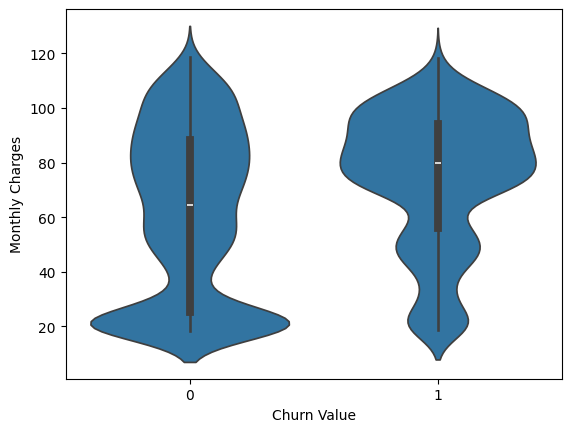

In [3]:
import seaborn as sns

sns.violinplot(data=df, x="Churn Value", y="Monthly Charges")

<Axes: xlabel='Contract', ylabel='count'>

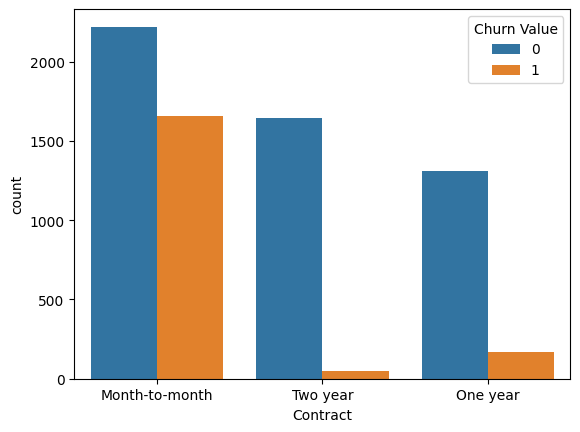

In [4]:
sns.countplot(data=df, x="Contract", hue="Churn Value")

<Axes: xlabel='Contract', ylabel='Churn Value'>

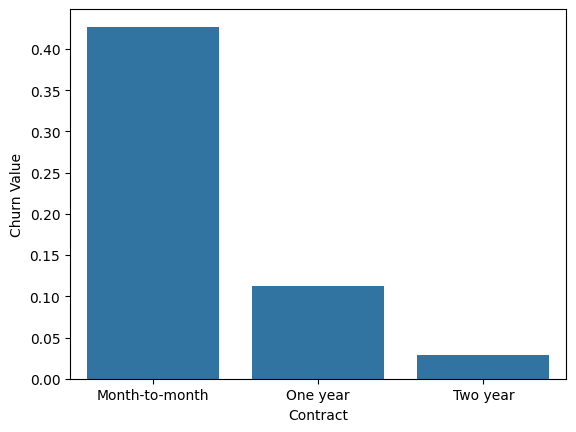

In [5]:
churn_rate = (
    df.groupby("Contract")["Churn Value"]
      .mean()
      .reset_index()
)

sns.barplot(data=churn_rate, x="Contract", y="Churn Value")

<Axes: xlabel='Online Security', ylabel='Churn Value'>

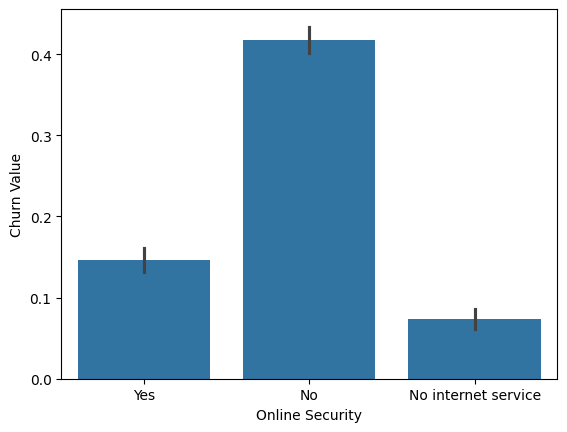

In [6]:
sns.barplot(data=df, x="Online Security", y="Churn Value")

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from src.features import build_preprocessor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from src.models import get_models
from sklearn.metrics import accuracy_score, roc_auc_score
from src.evaluation import evaluate_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [8]:
X = df.drop("Churn Value", axis=1)
y = df["Churn Value"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor = build_preprocessor(df)
models = get_models()

trained_pipelines = {}

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    trained_pipelines[name] = pipe

    results = evaluate_model(pipe, X_test, y_test)
    print(name, results)

logistic {'accuracy': 0.8019872249822569, 'roc_auc': 0.8488671885091322}
xgboost {'accuracy': 0.7863733144073811, 'roc_auc': 0.8320274354801209}


PermutationExplainer explainer: 5635it [03:23, 26.29it/s]                                                              


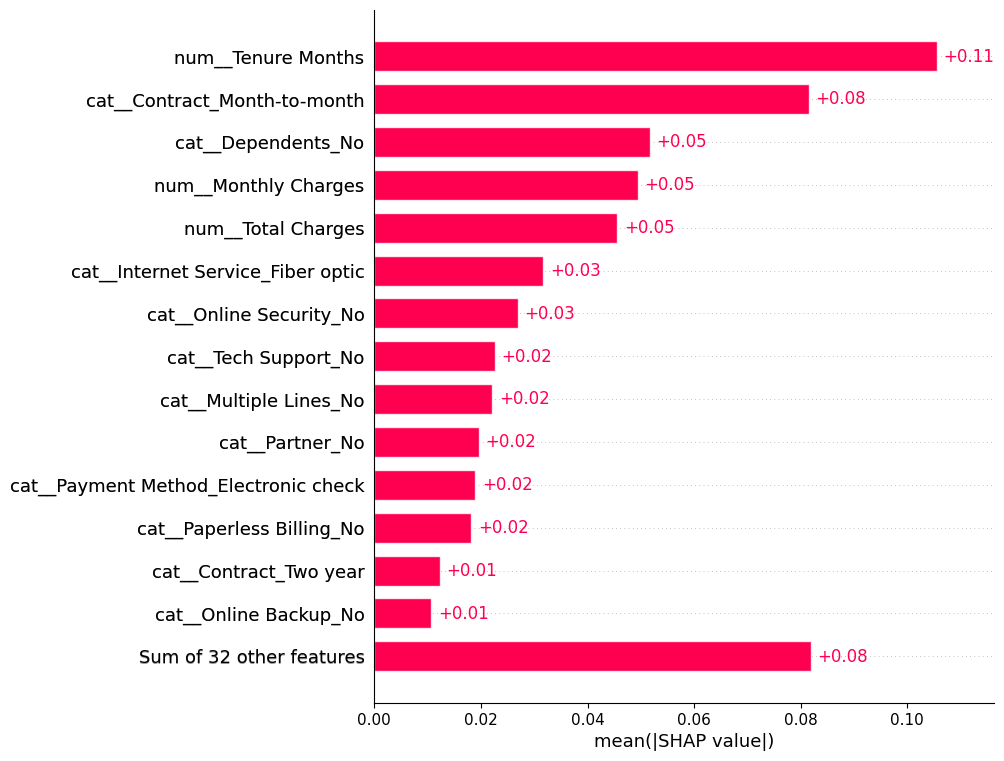

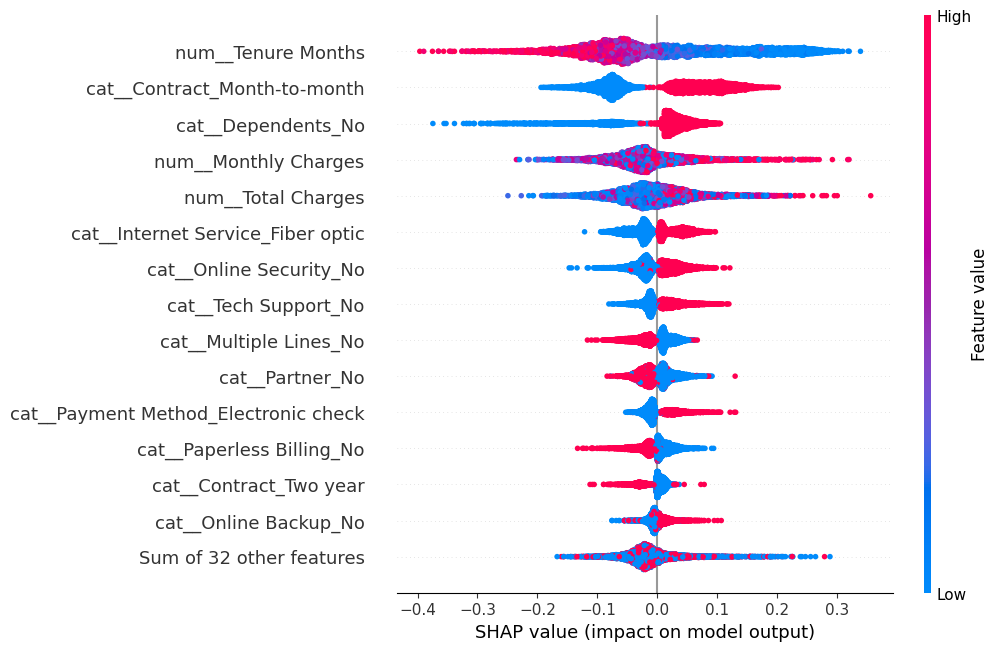

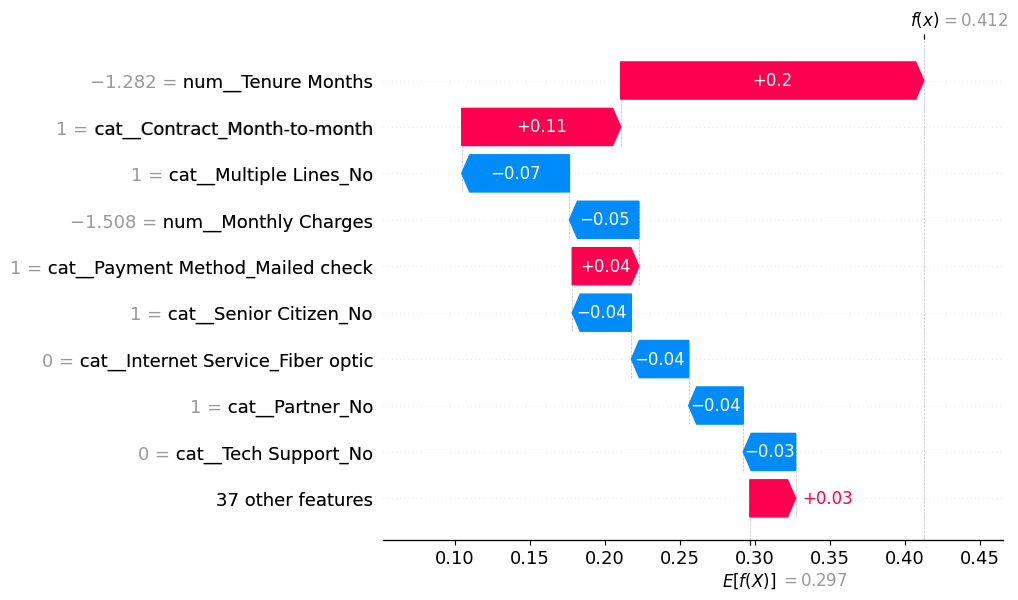

In [10]:
import shap

model_name = "xgboost"
pipe = trained_pipelines[model_name]

prep = pipe.named_steps["prep"]
model = pipe.named_steps["model"]

X_train_transformed = prep.transform(X_train)
feature_names = prep.get_feature_names_out()

#SHAP explainer
explainer = shap.Explainer(model.predict_proba, X_train_transformed, feature_names=feature_names)

#compute SHAP values for churns
shap_values = explainer(X_train_transformed)[:, :, 1]

#average feature importance
shap.plots.bar(shap_values, max_display=15)

#beeswarm
shap.plots.beeswarm(shap_values, max_display=15)

#single customer
customer_idx = 99
shap.plots.waterfall(shap_values[customer_idx])
